In [1]:
import SimpleITK as sitk
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import copy
import skimage.io 
import skimage.segmentation
import copy
import sklearn
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.distributions import studentT, normal, beta, exponential
import sys
import torch.optim as optim
import cv2, os, math
from PIL import Image
import requests
import ast
import pandas as pd
import shutil, random
from itertools import product
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()
%matplotlib inline

### Create Train Test Split

In [ ]:
#Split into train test folders
#75/25 train/test split
#Three classes ['cropped_IPMN_60', 'cropped_pdac_60', 'cropped_pnet_2']

train_dir = 'train'
test_dir = 'test'
dirnames = ['cropped_IPMN_60', 'cropped_pdac_60', 'cropped_pnet_2']

for dirname in dirnames:
    os.mkdir("test/"+dirname)
    for path_dir, dirnames, filenames in os.walk(train_dir+"/"+dirname):
        test_quantity = int((len(filenames)/100)*25)
        random_select = random.sample(filenames, test_quantity)
        for file in random_select:
            shutil.move("train/"+dirname+"/"+file, "test/"+dirname+"/"+file)

### Define Image Transformations

In [82]:
TRANSFORM_IMG = transforms.Compose(
    [transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(360),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224))])

TRANSFORM_IMG_TEST = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224))])

TRAIN_DATA_PATH = "pancreas_data/pancreas_data/traintest4/train2"
TEST_DATA_PATH = "pancreas_data/pancreas_data/traintest4/test2"

batch_size = 32

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 398
    Root location: pancreas_data/pancreas_data/traintest4/train2
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-360.0, 360.0], resample=False, expand=False)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
           )
Dataset ImageFolder
    Number of datapoints: 131
    Root location: pancreas_data/pancreas_data/traintest4/test2
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
           )


In [25]:
TRANSFORM_IMG_TEST = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224))])
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG_TEST)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [33]:
print(test_data.classes)

['cropped_IPMN_60', 'cropped_pdac_60', 'cropped_pnet_2']


### Create a CNN Architecture

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 16, 3, padding=1) #Channels in, Channels out, Filter size
        self.conv0_bn = nn.BatchNorm2d(16)      
        
        self.conv1 = nn.Conv2d(16, 32, 3, padding=1) 
        self.conv1_bn = nn.BatchNorm2d(32)  
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)  

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(128)  
        
        self.conv8 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8_bn = nn.BatchNorm2d(256)  
        
        self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.25)
        
        # fully conected layers:
        self.fc15 = nn.Linear(12544, 4096)
        self.fc16 = nn.Linear(4096, 512)
        self.fc17 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.conv0(x)
        x = F.relu(self.conv0_bn(x))
#         x = self.dropout(x)
        x= self.pool(x)
        
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
#         x = self.dropout(x)
        x= self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
#         x = self.dropout(x)
        x= self.pool(x)
        
        x = self.conv5(x)
        x = F.relu(self.conv5_bn(x))
#         x = self.dropout(x)   
        x = self.pool(x)
        
        x = self.conv8(x)
        x = F.relu(self.conv8_bn(x))
#         x = self.dropout(x)
        x = self.pool(x)

        x = x.reshape(-1, 12544)
        x = F.relu(self.fc15(x))
#         x = self.dropout(x)
        x = F.relu(self.fc16(x))
        x = self.fc17(x)
        return x

net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)

### Train the CNN Classifier

In [94]:
train_loss=[]
val_loss=[]

for epoch in range(40):  
    count_t=0
    count_v=0
    
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        count_t+=1
        
    train_loss.append(running_loss/count_t)
    print("Epoch ", epoch, "Train loss: ",running_loss/count_t)
    
    net.eval()
    running_loss_v = 0.0     
    for i_v, data_v in enumerate(testloader, 0):
            inputs_v, labels_v = data_v[0].to(device), data_v[1].to(device)
            
            outputs_v = net(inputs_v)
            loss_v = criterion(outputs_v, labels_v)

            running_loss_v += loss_v.item()
            count_v += 1 
        
    
    val_loss.append(running_loss_v/count_v)
    print("Epoch ", epoch, "Val loss: ",running_loss_v/count_v)
        
    if len(val_loss) == 1:
        print("Initial val loss saved")
        print("\n")
        torch.save(net.state_dict(), "pancreas_data/pancreas_data/weights5/pan.pth")
    else:
        if val_loss[-1] <= min(val_loss):
            print("Val loss saved")
            print("\n")
            torch.save(net.state_dict(), "pancreas_data/pancreas_data/weights5/pan_"+str(epoch)+"_.pth")
        else:
            print("\n")

print('Finished Training')


Epoch  0 Train loss:  1.1480673093062181
Epoch  0 Val loss:  1.052216351032257
Initial val loss saved


Epoch  1 Train loss:  0.9673408132333022
Epoch  1 Val loss:  1.0387350916862488
Val loss saved


Epoch  2 Train loss:  0.9504779714804429
Epoch  2 Val loss:  1.03415105342865
Val loss saved


Epoch  3 Train loss:  0.9506985957805927
Epoch  3 Val loss:  0.9216179013252258
Val loss saved


Epoch  4 Train loss:  0.9011432574345515
Epoch  4 Val loss:  0.8169188082218171
Val loss saved


Epoch  5 Train loss:  0.8223872780799866
Epoch  5 Val loss:  0.795502769947052
Val loss saved


Epoch  6 Train loss:  0.7349023360472459
Epoch  6 Val loss:  0.7244052052497864
Val loss saved


Epoch  7 Train loss:  0.702344128718743
Epoch  7 Val loss:  0.6828773796558381
Val loss saved


Epoch  8 Train loss:  0.7264720705839304
Epoch  8 Val loss:  0.6930437445640564


Epoch  9 Train loss:  0.6337742369908553
Epoch  9 Val loss:  0.9514057040214539


Epoch  10 Train loss:  0.6655586476509388
Epoch  10 Val l

In [120]:
#Model working on weights4 pan_29_pth
net1_loaded = Net()
net1_loaded.cuda()
net1_loaded.load_state_dict(torch.load("pancreas_data/pancreas_data/weights5/pan_30_works2.pth"))

<All keys matched successfully>

### Find Model Accuracy

In [121]:
# since we're not training, we don't need to calculate the gradients for our outputs
pred_labels = []
actual_labels = []

correct=0
total=0 
net1_loaded.eval()
y_pred = ""
outputs = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net1_loaded(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        

        predicted_list = predicted.tolist()
        pred_labels +=predicted_list
        labels_list = labels.tolist()
        actual_labels += labels_list
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        y_pred = predicted.cpu()
        

print('Accuracy on test images: %d %%' % (100 * correct / total))

Accuracy on test images: 80 %


### Find classifier performance scores and confusion matrix

In [122]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(actual_labels, pred_labels))
cm = confusion_matrix(actual_labels, pred_labels)
print(cm)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.83      0.80      0.81        65
           2       0.70      0.73      0.71        41

    accuracy                           0.81       131
   macro avg       0.83      0.83      0.83       131
weighted avg       0.81      0.81      0.81       131

[[24  1  0]
 [ 0 52 13]
 [ 1 10 30]]


### Plot Loss Graphs

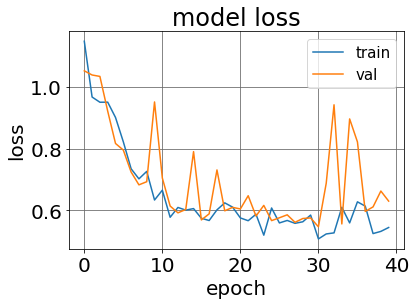

In [95]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss', fontsize = 20)
plt.xlabel('epoch', fontsize = 20)
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 15
# plt.rcParams['axes.facecolor'] = 'gainsboro'
plt.grid(color='dimgray')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('loss_panc_final_30_r.png', bbox_inches='tight')